In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
df=pd.read_excel("/content/CocaCola_Sales_Rawdata.xlsx")
df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [6]:
df.shape

(42, 2)

In [7]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

<Axes: xlabel='Quarter', ylabel='Sales'>

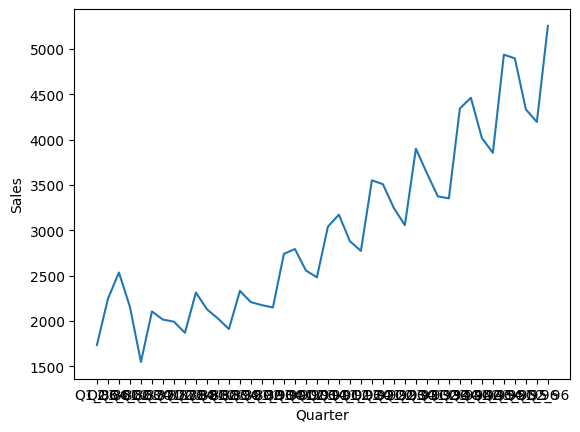

In [8]:
sns.lineplot(x="Quarter",y="Sales",data=df)

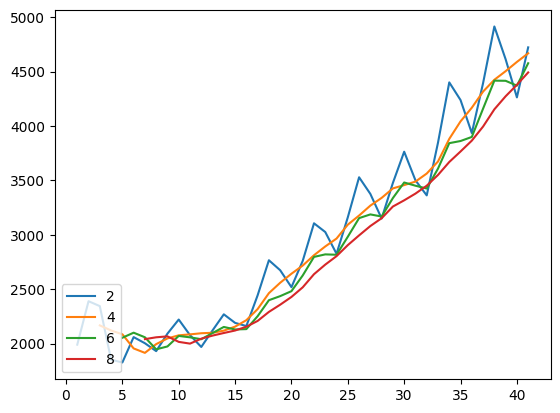

In [29]:
#Moving Average
for i in range(2,10,2):
   df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

<Figure size 1200x1000 with 0 Axes>

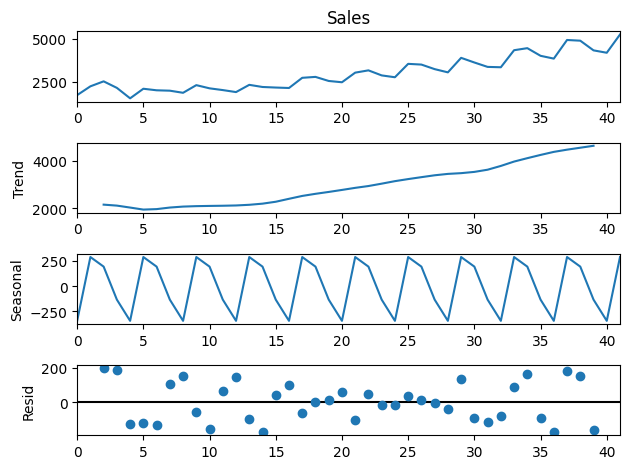

In [13]:

#Time Series Decomposition Plot
plt.figure(figsize=(12,10))
decompose_ts_add = seasonal_decompose(df.Sales,period=4)
decompose_ts_add.plot()
plt.show()

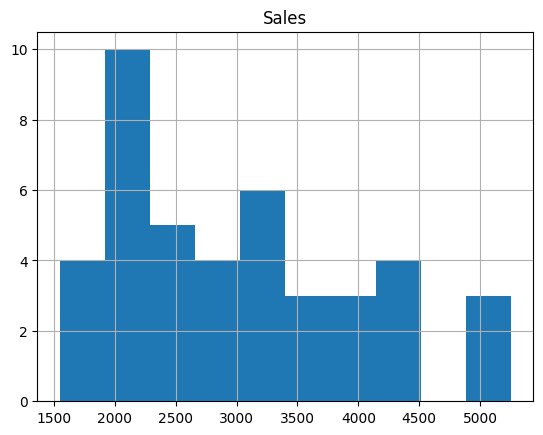

In [14]:
df.hist()
pyplot.show()

<Axes: >

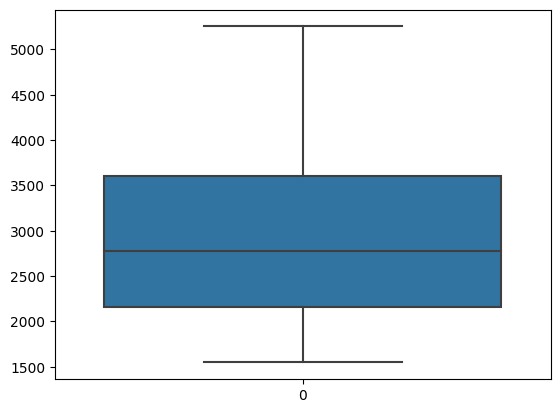

In [15]:
sns.boxplot(data=df['Sales'])

ACF & PACF

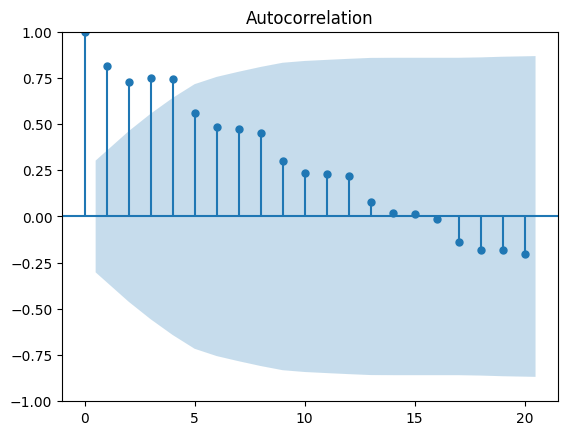

In [28]:
tsa_plots.plot_acf(df.Sales,lags=20)
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


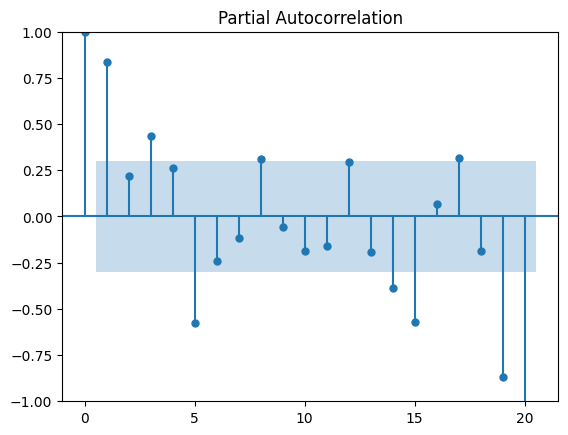

In [27]:
tsa_plots.plot_pacf(df.Sales,lags=20)
plt.show()

In [16]:
quarter =['Q1','Q2','Q3','Q4']
p = df["Quarter"][0]
p[0:2]
df['quarter']= 0

for i in range(42):
    p = df["Quarter"][i]
    df['quarter'][i]= p[0:2]

df.head()

<ipython-input-16-9c6f712b9811>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'][i]= p[0:2]


,Quarter,Sales,quarter
0,Q1_86,1734.827000,Q1
1,Q2_86,2244.960999,Q2
2,Q3_86,2533.804993,Q3
3,Q4_86,2154.962997,Q4
4,Q1_87,1547.818996,Q1


In [17]:
quarter_dummies = pd.DataFrame(pd.get_dummies(df['quarter']))
df1 = pd.concat([df,quarter_dummies],axis = 1)
df1.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1,1,0,0,0


In [18]:
df1["t"] = np.arange(1,43)
df1["t_squared"] = df1["t"]*df1["t"]
df1["log_Sales"] = np.log(df1["Sales"])
df1.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4,t,t_squared,log_Sales
0,Q1_86,1734.827000,Q1,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,1,0,0,0,5,25,7.344602


Linear  Model

In [30]:
Train = df1.head(30)
Test = df1.tail(12)

import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
print("RMSE Linear: ",rmse_linear)

RMSE Linear:  714.0144483281299


Exponential Model

In [31]:
Exp = smf.ols('log_Sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  552.2821039079217


Quadratic Model

In [32]:
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  646.2715428311304


Additive Seasonality

In [33]:
add_sea = smf.ols('Sales~Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1', 'Q2', 'Q3', 'Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  1778.0065467941367


Additive Seasonality Quadratic

In [34]:
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Q1', 'Q2', 'Q3', 'Q4','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
print("RMSE Additive Seasonality Quadratic:",rmse_add_sea_quad )

RMSE Additive Seasonality Quadratic: 586.0533067871008


Multiplicative Seasonality

In [35]:
Mul_sea = smf.ols('log_Sales~Q1+Q2+Q3+Q4',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
print("RMSE Multiplicative Seasonality:",rmse_Mult_sea)

RMSE Multiplicative Seasonality: 1828.9238912138117


Multiplicative Additive Seasonality

In [37]:
Mul_Add_sea = smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print("RMSE Multiplicative Additive Seasonality:",rmse_Mult_add_sea )

RMSE Multiplicative Additive Seasonality: 410.24970596082767


Testing

In [38]:
data1 = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data1)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,714.014448
1,rmse_Exp,552.282104
2,rmse_Quad,646.271543
3,rmse_add_sea,1778.006547
4,rmse_add_sea_quad,586.053307
5,rmse_Mult_sea,1828.923891
6,rmse_Mult_add_sea,410.249706


In [39]:
data = [['Q3_96', 'Q3'], ['Q4_96', 'Q4'], ['Q1_97', 'Q1'],['Q2_97', 'Q2']]
print(data)
forecast = pd.DataFrame(data, columns = ['Quarter', 'quarter'])
forecast

[['Q3_96', 'Q3'], ['Q4_96', 'Q4'], ['Q1_97', 'Q1'], ['Q2_97', 'Q2']]


,Quarter,quarter
0,Q3_96,Q3
1,Q4_96,Q4
2,Q1_97,Q1
3,Q2_97,Q2


Create dummies & T& T-Squared Columns

In [40]:
dummies = pd.DataFrame(pd.get_dummies(forecast['quarter']))
forecast1 = pd.concat([forecast,dummies],axis = 1)

forecast1["t"] = np.arange(1,5)   
forecast1["t_squared"] = forecast1["t"]*forecast1["t"] 
print("\nAfter Dummy, T and T-Square\n\n",forecast1.head())


After Dummy, T and T-Square

   Quarter quarter  Q1  Q2  Q3  Q4  t  t_squared
0   Q3_96      Q3   0   0   1   0  1          1
1   Q4_96      Q4   0   0   0   1  2          4
2   Q1_97      Q1   1   0   0   0  3          9
3   Q2_97      Q2   0   1   0   0  4         16


Forecasting using Additive Seasonality Quadratic Model

In [42]:
model_full = smf.ols('Sales~t+t_squared+Q1+Q2+Q3+Q4',data=df1).fit()
pred_new  = pd.Series(model_full.predict(forecast1))
pred_new

forecast1["forecasted_sales"] = pd.Series(pred_new)



Final Prediction For next 4 Quarters

In [43]:
Final_predict = forecast1.loc[:, ['Quarter', 'forecasted_sales']] 
Final_predict

,Quarter,forecasted_sales
0,Q3_96,2180.858824
1,Q4_96,1851.383709
2,Q1_97,1635.419724
3,Q2_97,2284.261547
